# Retrieve Route Attributes from List of Edges IDs and the Direction Travelled
We have a list of edges or turns (depending on the settings) from Dijkstra, and we need to get the route attributes (how many turns, how much feet up, miles of bike facility, etc) to report the route characterstics of a trip.

In [76]:
from pathlib import Path
import time
import geopandas as gpd
import numpy as np
import pickle
import networkx as nx
from shapely.ops import MultiLineString
import pandas as pd
import sys
import math

In [77]:
import json
config = json.load((Path.cwd().parent / 'config.json').open('rb'))
export_fp = Path(config['project_directory']) / 'Calibration'
cycleatl_fp = Path(config['project_directory']) / 'CycleAtlanta'
matching_fp = Path(config['project_directory']) / 'Map_Matching'
network_fp = Path(config['project_directory']) / 'Network'
if export_fp.exists() == False:
    export_fp.mkdir()

# Network Processing

In [78]:
turns_df = pd.read_parquet(network_fp/'turns_df.parquet')
edges_w_attr = gpd.read_file(network_fp/'final_network.gpkg',layer='edges')

In [79]:
#set index
edges_w_attr.set_index('linkid',inplace=True)
turns_df.set_index(['source_linkid','source_reverse_link','target_linkid','target_reverse_link'],inplace=True)

In [80]:
#unit conversions
edges_w_attr['length_mi'] = (edges_w_attr['length_ft'] / 5280).round(2)
edges_w_attr['ascent_ft'] = (edges_w_attr['ascent_m'] * 3.28084).round(0)
edges_w_attr['descent_ft'] = (edges_w_attr['descent_m'] * 3.28084).round(0)
edges_w_attr.drop(columns=['length_ft','ascent_m','descent_m'],inplace=True)

In [81]:
#get the columns that need to be reversed (within function)
ascent_columns = [col for col in edges_w_attr.columns if 'ascent' in col]
descent_columns = [col for col in edges_w_attr.columns if 'descent' in col]
bike_facils = ['facility_fwd','facility_rev']

In [82]:
#added a major/minor classification, everything else is just left as "road"
major_road = ['primary','secondary']
major_road = major_road + [item + '_link' for item in major_road]
minor_road = ['tertiary','unclassified','residential','service','trunk','living_street']
major_road = major_road + [item + '_link' for item in minor_road]
edges_w_attr.loc[edges_w_attr['highway'].isin(major_road),'link_type_new'] = 'major_road'
edges_w_attr.loc[edges_w_attr['highway'].isin(minor_road),'link_type_new'] = 'minor_road'
edges_w_attr.loc[edges_w_attr['link_type_new'].isna(),'link_type_new'] = edges_w_attr.loc[edges_w_attr['link_type_new'].isna(),'link_type']
edges_w_attr['major_road'] = edges_w_attr['link_type_new']=='major_road'

In [83]:
# boolean beltline variable
edges_w_attr['beltline'] = False
edges_w_attr.loc[edges_w_attr['name'].str.lower().str.contains('beltline') == True,'beltline'] = True

In [84]:
#do a motorized vs non-motorized split
edges_w_attr['vehicle_traffic'] = False
roads = ['primary', 'residential', 'service', 'secondary', 'tertiary',
       'secondary_link', 'unclassified','primary_link','tertiary_link','trunk', 'trunk_link', 'living_street']
edges_w_attr.loc[edges_w_attr['highway'].isin(roads),'vehicle_traffic'] = True

In [85]:
#change lts to text
edges_w_attr['lts'] = edges_w_attr['lts'].astype(str)

# Import Map Matched and Shortest Path Data (and impedance calibrated in the future)

In [86]:
# with (matching_fp / 'matched_0.pkl').open('rb') as fh:
#     matched_traces_dict = pickle.load(fh)
with (export_fp/'ready_for_calibration.pkl').open('rb') as fh:
    ready_for_calibration = pickle.load(fh)


In [87]:
ready_for_calibration.keys()
ready_for_calibration[80].keys()

dict_keys(['origin_node', 'destination_node', 'trip_start_time', 'match_ratio', 'matched_edges', 'shortest_edges'])

In [88]:
# match_ratio_array = np.array([item['match_ratio'] for key, item in matched_traces_dict.items() if isinstance(item,str)==False])
# (match_ratio_array > 0.9).sum()

In [89]:
# #get trip date for the bike facility check (add this in the prepare for calibration step)
# for key, item in ready_for_calibration.items():
#     ready_for_calibration[key]['start_time'] = matched_traces_dict.get(key,0)['trace'].iloc[0,2].year
# del matched_traces_dict

In [90]:
#more than 2 links
print('Initial:',len(ready_for_calibration))
ready_for_calibration = {key:item for key, item in ready_for_calibration.items() if (item['matched_edges'].shape[0] > 2) & (item['shortest_edges'].shape[0] > 2)}
print('Successful',len(ready_for_calibration))

Initial: 1825
Successful 1825


In [91]:
def route_attributes(tripid,match_dict_entry,edge_col,cols_to_summarize):
    '''
    Two different types of summarization:

    Instance based (turns, signals, bridges, etc)

    Length based on certain tag (bike facilities)

    Cumulative (length,elevation)

    '''

    summary_attributes = {}

    summary_attributes['tripid'] = tripid

    #get trip date for the bike facility check
    trip_date_year = match_dict_entry['trip_start_time']#trip_date_year = match_dict_entry['trace'].iloc[0,2].year

    #get route and turns
    route = [tuple(x) for x in match_dict_entry[edge_col].values]
    turns = [(route[i][0],route[i][1],route[i+1][0],route[i+1][1]) for i in range(0,len(route)-1)]
    
    #remove any doubling back (might be some of this in the matched dataset)
    turns = [turns for turns in turns if turns[0] != turns[2]]
    linkids = match_dict_entry[edge_col]['linkid'].tolist()
    reverse_links = match_dict_entry[edge_col]['reverse_link'].tolist()
    
    #get attributes
    route_w_attr = edges_w_attr.loc[linkids]
    turns_w_attr = turns_df.loc[turns]

    #add reverse direction
    route_w_attr['reverse_link'] = reverse_links

    #turn to gdf
    #route_w_attr = gpd.GeoDataFrame(route_w_attr,geometry='geometry',crs=config['projected_crs_epsg'])
    summary_attributes["geometry"] = MultiLineString([list(line.coords) for line in route_w_attr['geometry'].values])

    #flip relevant attributes
    route_w_attr.loc[route_w_attr['reverse_link']==True,ascent_columns+descent_columns+bike_facils] = \
        route_w_attr.loc[route_w_attr['reverse_link']==True,descent_columns+ascent_columns+bike_facils[::-1]].values

    #set no facility_fwd to nan
    route_w_attr.loc[route_w_attr['facility_fwd']=='no facility'] = None
    
    #create copies of the bike facility column to use that doesn't consider date
    #route_w_attr['facility_fwd_nd'] = route_w_attr['facility_fwd']

    #set the bike facility to na if the trip date was before the bike facility  
    route_w_attr.loc[route_w_attr['year'] > trip_date_year,bike_facils] = np.nan

    #summary columns
    summary_attributes["length_mi"] = route_w_attr['length_mi'].sum()
    summary_attributes["ascent_ft"] = route_w_attr['ascent_ft'].sum()
    summary_attributes["descent_ft"] = route_w_attr['descent_ft'].sum()

    # average grade by category (cut offs from broach)
    # should probably use pd.cut here instead
    # zero_to_two = (route_w_attr['ascent_grade_%'] >= 0) & (route_w_attr['ascent_grade_%'] < 2)
    # two_to_four = (route_w_attr['ascent_grade_%'] >= 2) & (route_w_attr['ascent_grade_%'] < 4)
    # four_to_six = (route_w_attr['ascent_grade_%'] >= 4) & (route_w_attr['ascent_grade_%'] < 6)
    # six_and_beyond = (route_w_attr['ascent_grade_%'] >= 6)
    # summary_attributes["(0,2]_prop"] = (route_w_attr.loc[zero_to_two,'length_mi'].sum() / route_w_attr['length_mi'].sum()).round(2)
    # summary_attributes["(2,4]_prop"] = (route_w_attr.loc[two_to_four,'length_mi'].sum() / route_w_attr['length_mi'].sum()).round(2)
    # summary_attributes["(4,6]_prop"] = (route_w_attr.loc[four_to_six,'length_mi'].sum() / route_w_attr['length_mi'].sum()).round(2)
    # summary_attributes["(6,inf)_prop"] = (route_w_attr.loc[six_and_beyond,'length_mi'].sum() / route_w_attr['length_mi'].sum()).round(2)

    # dillon version for visual clarity
    greater_than_four = (route_w_attr['ascent_grade_%'] > 4)
    summary_attributes["(4,inf)_prop"] = (route_w_attr.loc[greater_than_four,'length_mi'].sum() / route_w_attr['length_mi'].sum()).round(2)

    #TODO add this back in the elevation step and use the same limits?
    #add meters on grade segments (i.e. add all in length along x to x)
    #could possibly be a more accurate represntation of steep roads

    # #instance columns to summarize
    # count_cols = ['bridge','tunnel']
    # for count_col in count_cols:
    #     summary_attributes[count_col] = (route_w_attr[count_col]==True).sum().round(0)

    # length of route columns to summarize
    #cols = #['link_type_new','link_type','highway']#,'speedlimit_range_mph','lanes_per_direction']
    for col in cols_to_summarize:
        #make a summary column for every unique value in that column
        for unique_val in route_w_attr[col].unique():
            if isinstance(unique_val,str):
                summary_attributes[col+'_'+unique_val+'_prop'] = (route_w_attr.loc[route_w_attr[col]==unique_val,'length_mi'].sum() / route_w_attr['length_mi'].sum()).round(2)
            elif isinstance(unique_val,bool):
                #if bool just take the true value
                if unique_val == True:
                    summary_attributes[col+'_prop'] = (route_w_attr.loc[route_w_attr[col]==unique_val,'length_mi'].sum() / route_w_attr['length_mi'].sum()).round(2)
            elif isinstance(unique_val,float) & (unique_val==unique_val):
                new_unique_val = str(int(unique_val))
                summary_attributes[col+'_'+new_unique_val+'_prop'] = (route_w_attr.loc[route_w_attr[col]==unique_val,'length_mi'].sum() / route_w_attr['length_mi'].sum()).round(2)

    # turns
    summary_attributes.update(
        (turns_w_attr['turn_type'].value_counts() / route_w_attr['length_mi'].sum()).round(1).to_dict()
    )

    #signals
    summary_attributes['signalized'] = (turns_w_attr['signalized'].sum() / route_w_attr['length_mi'].sum()).round(1)

    return summary_attributes


In [92]:
cols_to_summarize = ['vehicle_traffic','facility_fwd','beltline','lts','major_road']

In [93]:
matched_summary = [route_attributes(key,item,'matched_edges',cols_to_summarize) for key, item in ready_for_calibration.items()]
matched_summary = pd.DataFrame.from_records(matched_summary)
matched_summary = gpd.GeoDataFrame(matched_summary,crs=config['projected_crs_epsg'])
matched_summary.fillna(0,inplace=True)
matched_summary.drop(columns=['tripid','geometry']).describe()

,length_mi,ascent_ft,descent_ft,"(4,inf)_prop",vehicle_traffic_prop,facility_fwd_sharrow_prop,facility_fwd_bike lane_prop,facility_fwd_cycletrack_prop,facility_fwd_multi use path_prop,lts_1_prop,...,lts_4_prop,straight,right,left,signalized,major_road_prop,beltline_prop,uturn,facility_fwd_buffered bike lane_prop,lts_0_prop
count,1825.000000,1825.000000,1825.000000,1825.000000,1825.000000,1825.000000,1825.000000,1825.000000,1825.00000,1825.000000,...,1825.000000,1825.000000,1825.000000,1825.000000,1825.000000,1825.000000,1825.000000,1825.000000,1825.000000,1825.000000
mean,3.867315,27.636164,-22.063562,0.022438,0.816049,0.046011,0.089989,0.003890,0.14040,0.207479,...,0.342685,31.181370,1.885589,1.796548,2.622192,0.286411,0.093079,0.015562,0.004855,0.002225
std,1.989356,85.137068,85.883089,0.026072,0.237530,0.080759,0.133244,0.018439,0.21048,0.236958,...,0.271605,10.247358,1.053969,0.996938,1.744278,0.273619,0.178846,0.080084,0.038300,0.015832
min,0.590000,-265.000000,-969.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.000000,6.700000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.240000,-20.000000,-67.000000,0.000000,0.670000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.130000,23.900000,1.200000,1.100000,1.400000,0.060000,0.000000,0.000000,0.000000,0.000000
50%,3.480000,22.000000,-17.000000,0.020000,0.940000,0.000000,0.030000,0.000000,0.00000,0.110000,...,0.290000,29.800000,1.800000,1.700000,2.200000,0.200000,0.000000,0.000000,0.000000,0.000000
75%,5.140000,70.000000,26.000000,0.030000,1.000000,0.060000,0.130000,0.000000,0.28000,0.370000,...,0.510000,38.200000,2.400000,2.300000,3.500000,0.460000,0.120000,0.000000,0.000000,0.000000
max,10.550000,1112.000000,266.000000,0.300000,1.000000,0.680000,0.910000,0.360000,1.00000,1.000000,...,1.000000,75.800000,8.100000,7.000000,9.500000,1.000000,1.000000,1.300000,0.780000,0.260000


In [94]:
shortest_summary = [route_attributes(key,item,'shortest_edges',cols_to_summarize) for key, item in ready_for_calibration.items()]
shortest_summary = pd.DataFrame.from_records(shortest_summary)
shortest_summary = gpd.GeoDataFrame(shortest_summary,crs=config['projected_crs_epsg'])
shortest_summary.fillna(0,inplace=True)
shortest_summary.drop(columns=['tripid','geometry']).describe()

,length_mi,ascent_ft,descent_ft,"(4,inf)_prop",vehicle_traffic_prop,facility_fwd_sharrow_prop,facility_fwd_bike lane_prop,lts_1_prop,lts_2_prop,lts_0_prop,...,major_road_prop,straight,left,right,signalized,facility_fwd_multi use path_prop,beltline_prop,facility_fwd_cycletrack_prop,uturn,facility_fwd_buffered bike lane_prop
count,1825.000000,1825.000000,1825.000000,1825.000000,1825.000000,1825.000000,1825.000000,1825.000000,1825.000000,1825.000000,...,1825.000000,1825.000000,1825.000000,1825.000000,1825.000000,1825.000000,1825.000000,1825.000000,1825.000000,1825.000000
mean,3.025786,-10.289315,-5.765479,0.023030,0.736000,0.027036,0.047836,0.117896,0.182729,0.149375,...,0.284685,33.392603,3.339452,3.341973,2.305315,0.063622,0.051545,0.001151,0.003342,0.005041
std,1.598981,74.176973,72.928880,0.028632,0.239407,0.063597,0.101611,0.171911,0.168592,0.144960,...,0.278137,10.438766,2.136499,2.116260,1.674735,0.145910,0.140064,0.016239,0.042853,0.034851
min,0.350000,-824.000000,-342.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,4.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.760000,-50.000000,-46.000000,0.000000,0.600000,0.000000,0.000000,0.000000,0.050000,0.030000,...,0.020000,26.200000,1.800000,1.800000,1.100000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.700000,-8.000000,-2.000000,0.010000,0.800000,0.000000,0.000000,0.050000,0.140000,0.110000,...,0.230000,32.700000,2.900000,3.000000,2.100000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,3.940000,31.000000,35.000000,0.040000,0.930000,0.020000,0.040000,0.160000,0.260000,0.230000,...,0.460000,40.300000,4.500000,4.500000,3.100000,0.050000,0.000000,0.000000,0.000000,0.000000
max,9.050000,400.000000,872.000000,0.240000,1.000000,0.610000,0.850000,1.000000,0.990000,0.850000,...,1.000000,102.600000,15.100000,16.000000,14.900000,1.000000,1.000000,0.430000,0.900000,0.740000


In [95]:
shortest_summary.columns

Index(['tripid', 'geometry', 'length_mi', 'ascent_ft', 'descent_ft',
       '(4,inf)_prop', 'vehicle_traffic_prop', 'facility_fwd_sharrow_prop',
       'facility_fwd_bike lane_prop', 'lts_1_prop', 'lts_2_prop', 'lts_0_prop',
       'lts_4_prop', 'lts_3_prop', 'major_road_prop', 'straight', 'left',
       'right', 'signalized', 'facility_fwd_multi use path_prop',
       'beltline_prop', 'facility_fwd_cycletrack_prop', 'uturn',
       'facility_fwd_buffered bike lane_prop'],
      dtype='object')

In [96]:
renaming_dict = {
    '(0,2]_prop': "0-2% grade", 
    '(2,4]_prop': "2-4% grade", 
    '(4,6]_prop': "4-6% grade", 
    '(6,inf)_prop': "> 6% grade", 
    '(4,inf)_prop': "> 4% grade",
    'ascent_ft': "Ascent (ft)",
    'descent_ft': "Descent (ft)", 
    'beltline_prop': "On BeltLine", 
    'facility_fwd_bike lane_prop': "Bike Lane",
    'facility_fwd_buffered bike lane_prop': "Buffered Bike Lane", 
    'facility_fwd_cycletrack_prop': "Cycletrack",
    'facility_fwd_multi use path_prop': "Multi-Use Path", 
    'facility_fwd_sharrow_prop': "Sharrow or Bike Route", 
    'left': "Left Turn (per mi)",
    'length_mi': "Length (mi)", 
    'right': "Right Turn (per mi)", 
    'straight': "Straight", 
    'uturn': " U-Turn (per mi)", 
    'vehicle_traffic_prop': "Vehicle Traffic Allowed",
    'lts_0_prop': "LTS Not Rated",
    'lts_1_prop': "LTS 1",
    'lts_2_prop': "LTS 2",
    'lts_3_prop': "LTS 3",
    'lts_4_prop': "LTS 4",
}

In [97]:
x_axes_limits = {
    # '(0,2]_prop': "0-2% grade", 
    # '(2,4]_prop': "2-4% grade", 
    # '(4,6]_prop': "4-6% grade", 
    # '(6,inf)_prop': "> 6% grade", 
    '(4,inf)_prop': (-0.2,0.2),
    'ascent_ft': (-1000,1000),
    #'descent_ft': "Descent (ft)", 
    'beltline_prop': (-0.6,0.6), 
    'facility_fwd_bike lane_prop': (-0.4,0.4),
    'facility_fwd_buffered bike lane_prop': (-0.1,0.1), 
    'facility_fwd_cycletrack_prop': (-0.5,0.5),
    'facility_fwd_multi use path_prop': (-0.6,0.6), 
    'facility_fwd_sharrow_prop': (-0.3,0.3), 
    #'left': "Left Turn",
    'length_mi': (0,6), 
    #'right': "Right Turn", 
    #'straight': "Straight", 
    #'uturn': " U-Turn", 
    'vehicle_traffic_true_prop': (-0.75,0.75),
    #'lts': "LTS"
}

In [98]:
#select which differences to plot and what order to plot
cols_to_plot = ['length_mi', 'ascent_ft',
       '(4,inf)_prop', 'vehicle_traffic_prop', 'beltline_prop', 
       'facility_fwd_sharrow_prop','facility_fwd_bike lane_prop',
       'facility_fwd_buffered bike lane_prop',
       'facility_fwd_cycletrack_prop', 'facility_fwd_multi use path_prop',
       'lts_1_prop','lts_2_prop','lts_3_prop','lts_4_prop',
       'uturn', 'straight', 'right', 'left','signalized'
]

# Visualize Chosen Attributes

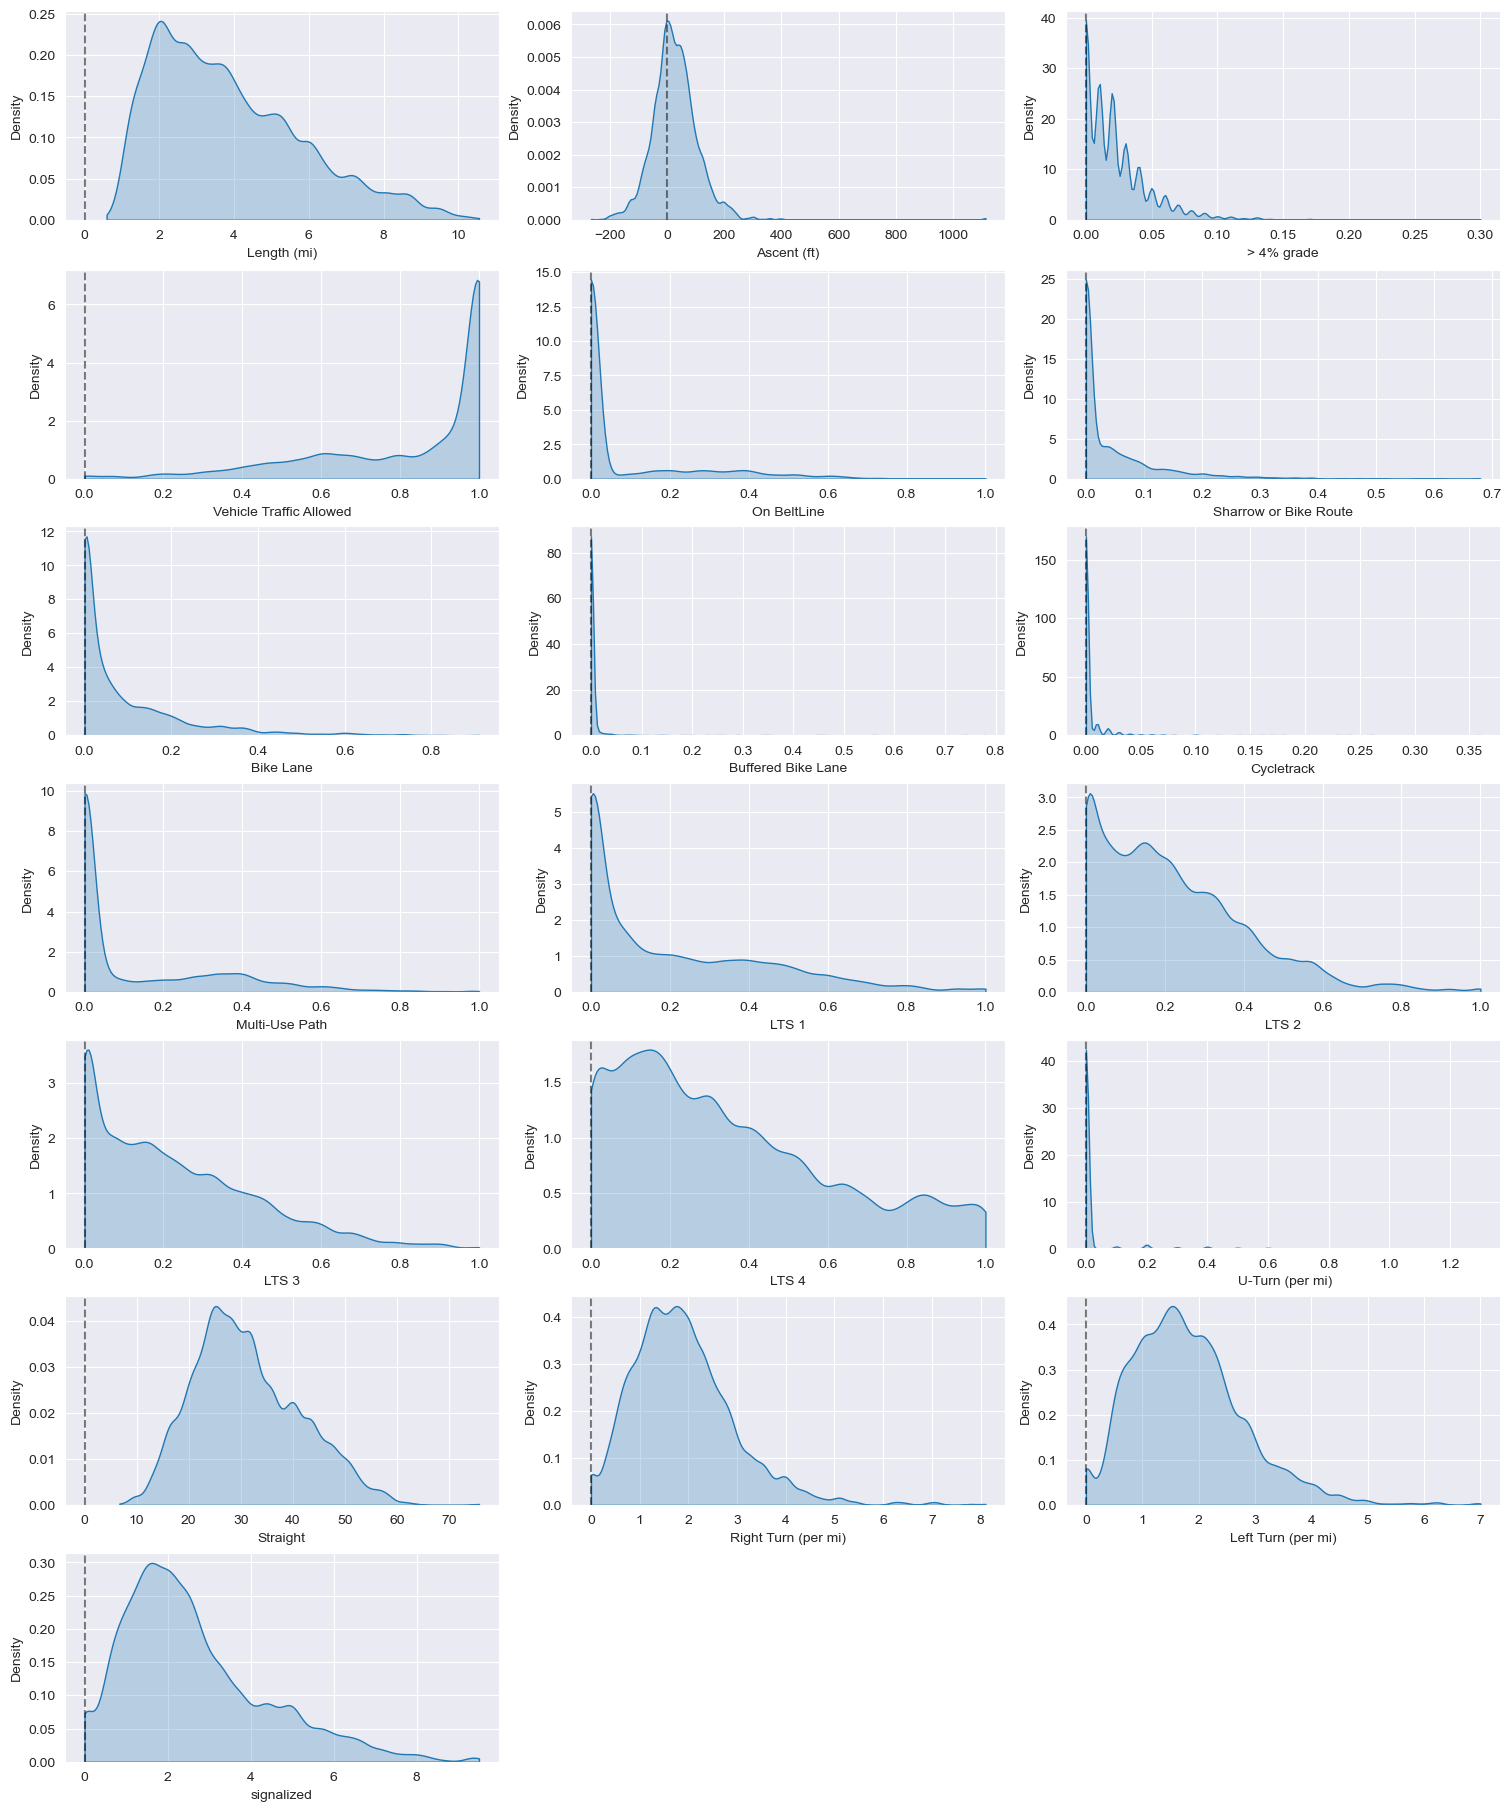

In [99]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd


# Define the variables to plot
variables = cols_to_plot

# Number of variables
num_vars = len(variables)

# Determine grid size (e.g., 2x2)
ncols = 3
nrows = (num_vars // ncols) + (num_vars % ncols > 0)

# Create subplots
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 18), constrained_layout=True)

# Set the background color of the figure
sns.set_style("darkgrid")

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Plot each KDE plot on a separate subplot
for ax, variable in zip(axes, variables):
    sns.kdeplot(data=matched_summary, x=variable, fill=True, ax=ax, cut=0, bw_adjust=0.5)
    #ax.set_title(renaming_dict.get(variable,variable))
    ax.set_xlabel(renaming_dict.get(variable,variable))

    # # Get the min and max values of the variable
    # min_val = matched_summary[variable].min()
    # max_val = matched_summary[variable].max()
    
    # # Calculate symmetric limits around zero
    # max_abs_val = max(abs(min_val), abs(max_val))
    # x_lim = (-max_abs_val, max_abs_val)

    # # #set varaible specific limits
    # # if x_axes_limits.get(variable,False) != False:
    # #     x_lim = x_axes_limits.get(variable,x_lim)
    
    # ax.set_xlim(x_lim)
    ax.axvline(0, color='k', linestyle='--', alpha = 0.5)  # Optional: add a vertical line at zero for reference

    # Set the background color of the axes
    #ax.set_facecolor('grey')
    #ax.grid(True, color='white')

# Remove any empty subplots
for ax in axes[len(variables):]:
    fig.delaxes(ax)

# Show the plot
plt.show()


# Visualize Path Attribute Differences (Chosen - Shortest)
Re-create the plots that were in Dillon's paper.

In [100]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

In [101]:
differences = matched_summary.iloc[:,2:] - shortest_summary.iloc[:,2:]

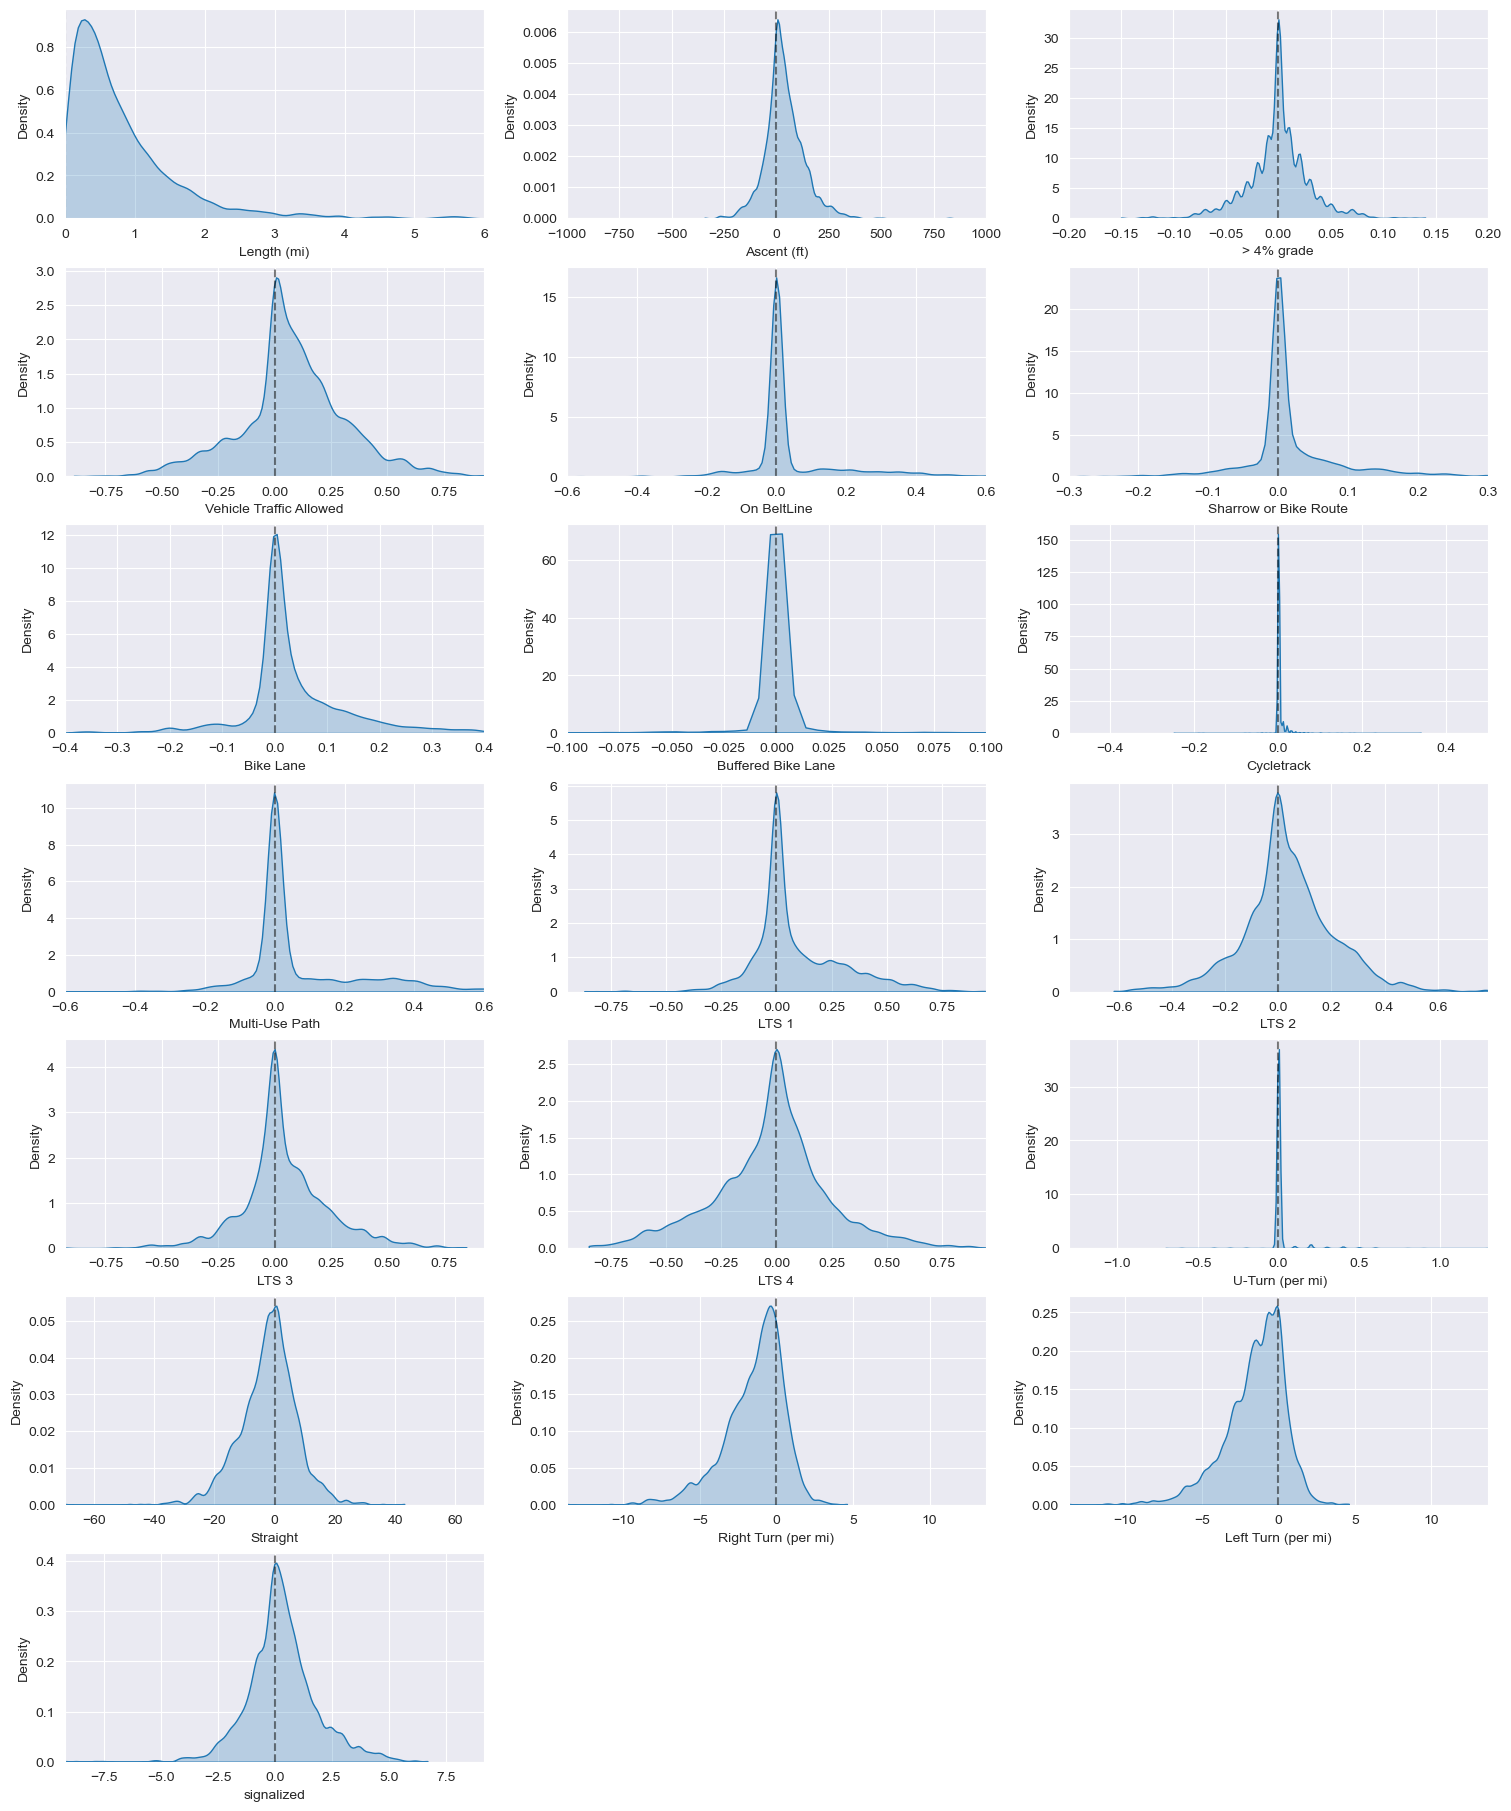

In [102]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd


# Define the variables to plot
variables = cols_to_plot

# Number of variables
num_vars = len(variables)

# Determine grid size (e.g., 2x2)
ncols = 3
nrows = (num_vars // ncols) + (num_vars % ncols > 0)

# Create subplots
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 18), constrained_layout=True)

# Set the background color of the figure
sns.set_style("darkgrid")

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Plot each KDE plot on a separate subplot
for ax, variable in zip(axes, variables):
    sns.kdeplot(data=differences, x=variable, fill=True, ax=ax, cut=0, bw_adjust=0.5)
    #ax.set_title(renaming_dict.get(variable,variable))
    ax.set_xlabel(renaming_dict.get(variable,variable))

    # Get the min and max values of the variable
    min_val = differences[variable].min()
    max_val = differences[variable].max()
    
    # Calculate symmetric limits around zero
    max_abs_val = max(abs(min_val), abs(max_val))
    x_lim = (-max_abs_val, max_abs_val)

    #set varaible specific limits
    if x_axes_limits.get(variable,False) != False:
        x_lim = x_axes_limits.get(variable,x_lim)
    
    ax.set_xlim(x_lim)
    ax.axvline(0, color='k', linestyle='--', alpha = 0.5)  # Optional: add a vertical line at zero for reference

    # Set the background color of the axes
    #ax.set_facecolor('grey')
    #ax.grid(True, color='white')

# Remove any empty subplots
for ax in axes[len(variables):]:
    fig.delaxes(ax)

# Show the plot
plt.show()


In [103]:
differences.rename(columns=renaming_dict).describe().round(2)

,> 4% grade,Ascent (ft),On BeltLine,Descent (ft),Bike Lane,Buffered Bike Lane,Cycletrack,Multi-Use Path,Sharrow or Bike Route,Left Turn (per mi),...,LTS 1,LTS 2,LTS 3,LTS 4,major_road_prop,Right Turn (per mi),signalized,Straight,U-Turn (per mi),Vehicle Traffic Allowed
count,1825.00,1825.00,1825.00,1825.00,1825.00,1825.00,1825.00,1825.00,1825.00,1825.00,...,1825.00,1825.00,1825.00,1825.00,1825.00,1825.00,1825.00,1825.00,1825.00,1825.00
mean,-0.00,37.93,0.04,-16.30,0.04,-0.00,0.00,0.08,0.02,-1.54,...,0.09,0.04,0.05,-0.03,0.00,-1.46,0.32,-2.21,0.01,0.08
std,0.03,99.91,0.15,100.35,0.13,0.04,0.02,0.18,0.08,2.00,...,0.21,0.17,0.20,0.26,0.26,1.98,1.56,9.59,0.09,0.24
min,-0.15,-343.00,-0.81,-960.00,-0.54,-0.56,-0.25,-0.81,-0.56,-13.70,...,-0.87,-0.62,-0.93,-0.85,-0.89,-13.70,-9.20,-69.60,-0.70,-0.89
25%,-0.01,-14.00,0.00,-62.00,0.00,0.00,0.00,0.00,0.00,-2.60,...,-0.01,-0.05,-0.05,-0.16,-0.11,-2.50,-0.50,-7.60,0.00,-0.01
50%,0.00,26.00,0.00,-14.00,0.00,0.00,0.00,0.00,0.00,-1.20,...,0.01,0.02,0.01,0.00,0.00,-1.10,0.20,-1.60,0.00,0.07
75%,0.01,85.00,0.00,33.00,0.07,0.00,0.00,0.13,0.03,-0.10,...,0.19,0.13,0.14,0.11,0.11,-0.10,1.10,3.40,0.00,0.21
max,0.14,1098.00,0.85,402.00,0.78,0.56,0.34,0.92,0.56,4.60,...,0.95,0.79,0.85,0.95,0.94,4.60,6.70,43.00,1.30,0.93


# Cross Tabs

In [104]:
with (cycleatl_fp/'trips_3.pkl').open('rb') as fh:
    trips = pickle.load(fh)
with (cycleatl_fp/'users_0.pkl').open('rb') as fh:
    users = pickle.load(fh)

In [105]:
trips.columns

Index(['tripid', 'userid', 'remapped_userid', 'start_X', 'start_Y', 'end_X',
       'end_Y', 'start_label', 'end_label', 'sort_start_label',
       'sort_end_label', 'reverse_trajectory', 'trip_patterns',
       'trip_pattern_prevalence', 'trip_type', 'description',
       'total_distance_ft', 'avg_speed_mph'],
      dtype='object')

In [106]:
users.columns

Index(['userid', 'created_date', 'email', 'age', 'gender', 'income',
       'ethnicity', 'homeZip', 'schoolZip', 'workZip', 'cycling_freq',
       'rider_history', 'rider_type', 'count'],
      dtype='object')

In [107]:
#pretend they're not the same person for now and then later fix the cycleatl data processing code

In [108]:
differences['tripid'] = matched_summary['tripid']

In [109]:
differences_w_info = differences.merge(pd.merge(trips,users,on='userid'),on='tripid')

In [110]:
differences_w_info['rider_type'].value_counts()

Enthused & confident         693
Strong & fearless            456
Comfortable, but cautious    376
NULL                         290
Interested, but concerned     10
Name: rider_type, dtype: int64

In [111]:
trips.columns

Index(['tripid', 'userid', 'remapped_userid', 'start_X', 'start_Y', 'end_X',
       'end_Y', 'start_label', 'end_label', 'sort_start_label',
       'sort_end_label', 'reverse_trajectory', 'trip_patterns',
       'trip_pattern_prevalence', 'trip_type', 'description',
       'total_distance_ft', 'avg_speed_mph'],
      dtype='object')

In [112]:
users.columns

Index(['userid', 'created_date', 'email', 'age', 'gender', 'income',
       'ethnicity', 'homeZip', 'schoolZip', 'workZip', 'cycling_freq',
       'rider_history', 'rider_type', 'count'],
      dtype='object')

In [113]:
hue = "rider_type"

c:\Users\tpassmore6\Anaconda3\envs\geo-env\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
c:\Users\tpassmore6\Anaconda3\envs\geo-env\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
c:\Users\tpassmore6\Anaconda3\envs\geo-env\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


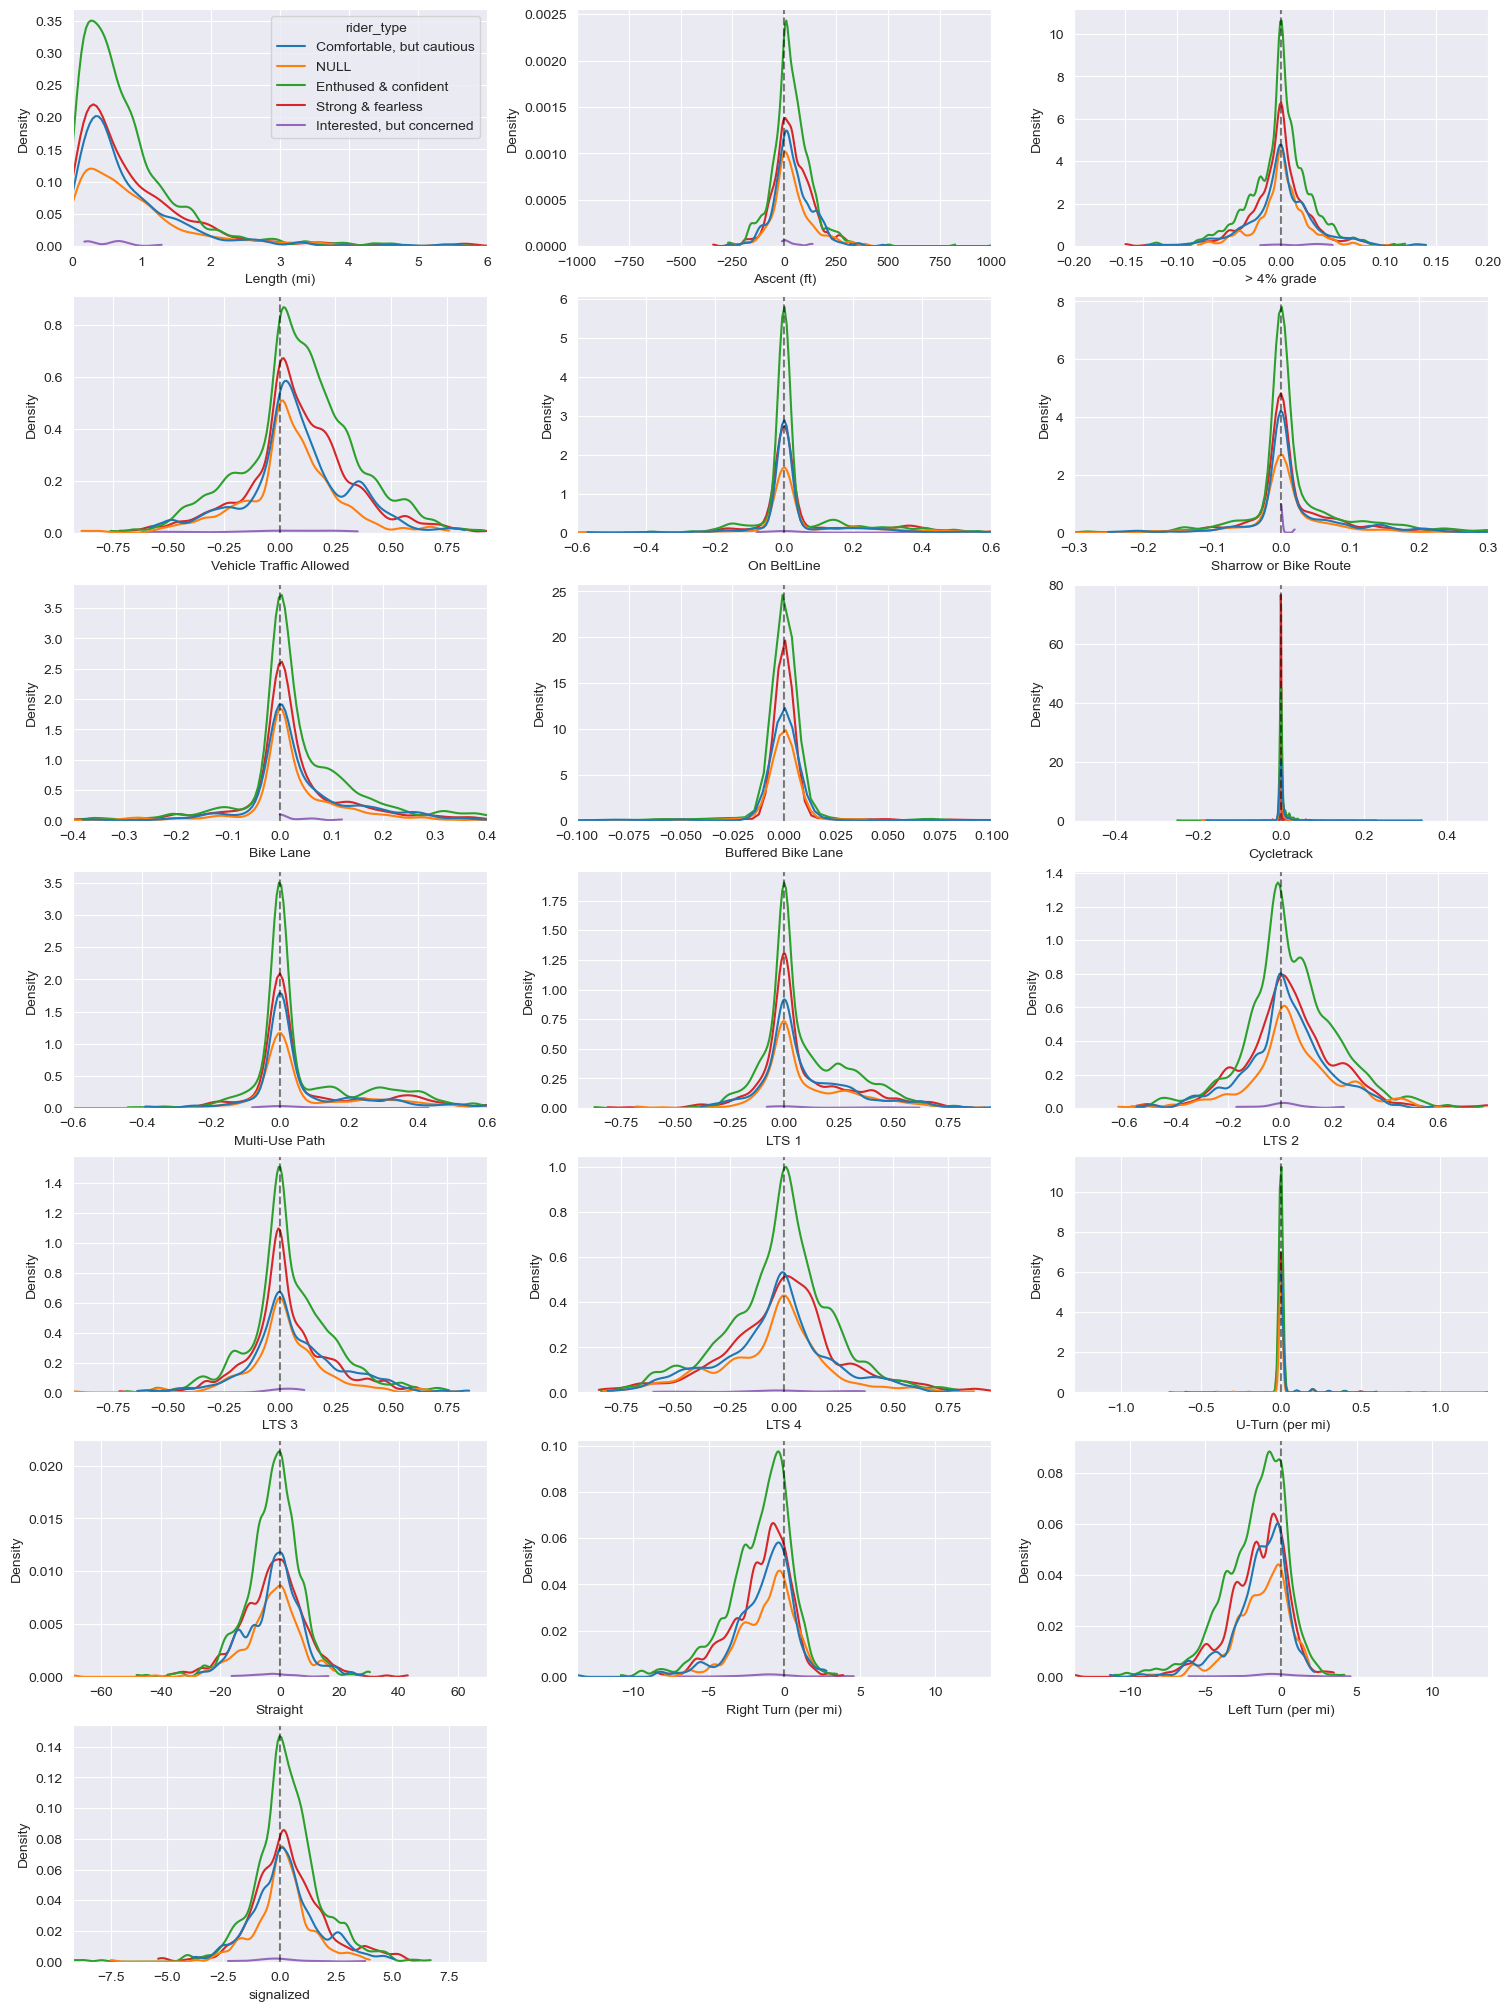

In [114]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd


# Define the variables to plot
variables = cols_to_plot

# Number of variables
num_vars = len(variables)

# Determine grid size (e.g., 2x2)
ncols = 3
nrows = (num_vars // ncols) + (num_vars % ncols > 0)

# Create subplots
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 20), constrained_layout=True)

# Set the background color of the figure
sns.set_style("darkgrid")

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Plot each KDE plot on a separate subplot
i = 0
for ax, variable in zip(axes, variables):
    if i == 0:
        sns.kdeplot(data=differences_w_info, x=variable, fill=False, ax=ax, cut=0, bw_adjust=0.5, hue=hue)
        i += 1
    else:
        sns.kdeplot(data=differences_w_info, x=variable, fill=False, ax=ax, cut=0, bw_adjust=0.5, hue=hue, legend = False)
    #ax.set_title(renaming_dict.get(variable,variable))
    ax.set_xlabel(renaming_dict.get(variable,variable))

    # Get the min and max values of the variable
    min_val = differences_w_info[variable].min()
    max_val = differences_w_info[variable].max()
    
    # Calculate symmetric limits around zero
    max_abs_val = max(abs(min_val), abs(max_val))
    x_lim = (-max_abs_val, max_abs_val)

    #set varaible specific limits
    if x_axes_limits.get(variable,False) != False:
        x_lim = x_axes_limits.get(variable,x_lim)
    
    ax.set_xlim(x_lim)
    ax.axvline(0, color='k', linestyle='--', alpha = 0.5)  # Optional: add a vertical line at zero for reference

# Remove any empty subplots
for ax in axes[len(variables):]:
    fig.delaxes(ax)

# Show the plot
plt.show()


In [115]:
#multiple_entries = users['userid'].apply(lambda x: isinstance(x,list))

#users['rider_type'].apply()
# def list_to_single(row):
#     if isinstance(row['userid'],list) == False:
#         return row
    
#     #remove nulls
#     if isinstance(row['rider_type'],list):


#     row["rider_type"]


In [116]:
#have a bad elevation link
edges_w_attr.loc[edges_w_attr['ascent_ft'].sort_values(ascending=False).head(10).index,['name','ascent_ft','descent_ft','geometry']].explore()

In [117]:
matched_summary.loc[[matched_summary['ascent_ft'].idxmax()]].explore()

In [118]:
differences.sort_values('ascent_ft',ascending=False).head(10)

,"(4,inf)_prop",ascent_ft,beltline_prop,descent_ft,facility_fwd_bike lane_prop,facility_fwd_buffered bike lane_prop,facility_fwd_cycletrack_prop,facility_fwd_multi use path_prop,facility_fwd_sharrow_prop,left,...,lts_2_prop,lts_3_prop,lts_4_prop,major_road_prop,right,signalized,straight,uturn,vehicle_traffic_prop,tripid
1138,0.10,1098.0,0.00,-960.0,-0.01,0.00,0.0,0.00,0.05,0.6,...,0.04,0.09,-0.10,-0.22,1.3,-1.1,-14.9,0.0,0.00,14590
384,0.13,1017.0,0.00,-891.0,0.05,0.00,0.0,0.00,0.18,-1.4,...,0.19,-0.64,0.54,0.37,2.5,3.4,-1.4,0.0,0.11,3254
1515,-0.02,825.0,0.00,-887.0,0.03,0.08,0.0,0.00,0.00,-1.9,...,-0.01,-0.05,0.30,0.37,-1.5,2.9,1.7,0.0,0.36,27028
1340,0.02,504.0,0.00,-211.0,0.00,0.00,0.0,0.00,0.00,-1.1,...,-0.10,-0.15,0.30,0.24,-0.9,1.0,4.3,0.0,0.06,24126
129,0.02,477.0,0.11,-79.0,0.16,0.00,0.0,0.11,0.01,-0.6,...,0.06,0.17,0.00,0.27,0.3,0.4,-10.1,0.0,0.24,767
1143,0.01,390.0,0.26,112.0,0.10,0.00,0.0,0.26,0.00,-1.4,...,0.23,0.18,-0.20,-0.13,-1.0,-0.6,-8.0,0.0,0.23,14678
515,-0.01,385.0,0.00,-367.0,0.03,0.00,0.0,0.00,0.00,-0.7,...,0.31,0.09,-0.20,0.13,0.1,0.2,3.3,0.0,0.10,4755
829,0.09,368.0,0.00,28.0,0.00,0.00,0.0,0.00,0.00,-0.5,...,0.33,-0.27,-0.06,0.51,-0.1,-0.9,-13.9,0.0,0.00,9036
844,0.01,364.0,0.00,-339.0,-0.14,0.01,0.0,0.01,0.02,0.4,...,-0.14,-0.41,0.51,-0.07,0.5,0.6,-0.7,0.0,-0.03,9221
670,0.01,362.0,0.00,-181.0,0.02,0.00,0.0,0.00,0.16,-0.6,...,0.13,0.23,-0.30,-0.38,-1.0,-1.4,1.8,0.0,0.13,6988


In [119]:
sns.kdeplot(data=matched_summary[link_type_new],cut=0,bw_adjust=5)

NameError: name 'link_type_new' is not defined

# Deprecated past here

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score

df = summary_df.copy()

# Assuming your dataframe is named df
# Drop any rows with missing values (if any)
df.fillna(0,inplace=True)

# Define features and target variable
X = df.drop(columns=['tripid', 'geometry', 'length_ft'])
y = df['length_ft']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the model
regressor = DecisionTreeRegressor(random_state=42)

# Train the model
regressor.fit(X_train, y_train)

# Predict on the test set
y_pred = regressor.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")


In [ ]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plot_tree(regressor, feature_names=X.columns, filled=True, rounded=True)
plt.show()


In [ ]:
feature_importances = pd.Series(regressor.feature_importances_, index=X.columns).sort_values(ascending=False)
print(feature_importances)


In [ ]:
import random
testtrip = random.choice(list(matched_traces_dict.keys()))
testtrip = matched_traces_dict[testtrip]

In [ ]:
summary_dict = {}

#get edges
route = testtrip['edges']


In [ ]:
#get route and turns
route = [tuple(x) for x in testtrip['edges'].values]
turns = [(route[i][0],route[i][1],route[i+1][0],route[i+1][1]) for i in range(0,len(route)-1)]

In [ ]:
'''
Two different types of summarization:

Instance based (turns, signals, bridges, etc)

Length based on certain tag (bike facilities)

Cumulative (length,elevation)

'''

summary_attributes = {}

#get trip date for the bike facility check
trip_date_year = testtrip['trace'].iloc[0,2].year

#get route and turns
route = testtrip['edges']
turns = [(route.values[i][0],route.values[i][1],route.values[i+1][0],route.values[i+1][1]) for i in range(0,len(route.values)-1)]
turns = pd.DataFrame(turns,columns=['source_linkid','source_reverse_link','target_linkid','target_reverse_link'])


In [ ]:

#retrieve attributes
route_w_attr = pd.merge(route,edges_w_attr,on='linkid')
turns_w_attr = pd.merge(turns,turns_df,on=['source_linkid','source_reverse_link','target_linkid','target_reverse_link'])

#turn to gdf
route_w_attr = gpd.GeoDataFrame(route_w_attr,geometry='geometry',crs=config['projected_crs_epsg'])
summary_attributes["geometry"] = MultiLineString(route_w_attr['geometry'].tolist())

#flip relevant attributes
route_w_attr.loc[route_w_attr['reverse_link']==True,ascent_columns+descent_columns+bike_facils] = \
    route_w_attr.loc[route_w_attr['reverse_link']==True,descent_columns+ascent_columns+bike_facils[::-1]].values

#set the bike facility to na if the trip date was before the bike facility
route_w_attr.loc[route_w_attr['year'] > trip_date_year,bike_facils] = np.nan

#summary columns
summary_attributes["length_ft"] = route_w_attr['length_ft'].sum().round(0)
summary_attributes["ascent_m"] = route_w_attr['ascent_m'].sum().round(0)
summary_attributes["descent_m"] = route_w_attr['descent_m'].sum().round(0)

# average grade by category (from broach)
zero_to_two = (route_w_attr['ascent_grade_%'] > 0) & (route_w_attr['ascent_grade_%'] <= 2)
two_to_four = (route_w_attr['ascent_grade_%'] > 2) & (route_w_attr['ascent_grade_%'] <= 4)
four_to_six = (route_w_attr['ascent_grade_%'] > 4) & (route_w_attr['ascent_grade_%'] <= 6)
six_and_beyond = (route_w_attr['ascent_grade_%'] > 6)
summary_attributes["zero_to_two_%_ft"] = route_w_attr.loc[zero_to_two,'length_ft'].sum().round(0)
summary_attributes["two_to_four_%_ft"] = route_w_attr.loc[two_to_four,'length_ft'].sum().round(0)
summary_attributes["four_to_six_%_ft"] = route_w_attr.loc[four_to_six,'length_ft'].sum().round(0)
summary_attributes["six_and_beyond_%_ft"] = route_w_attr.loc[six_and_beyond,'length_ft'].sum().round(0)

#TODO add this back in the elevation step and use the same limits?
#add meters on grade segments (i.e. add all in length along x to x)
#could possibly be a more accurate represntation of steep roads

# #instance columns to summarize
# count_cols = ['bridge','tunnel']
# for count_col in count_cols:
#     summary_attributes[count_col] = (route_w_attr[count_col]==True).sum().round(0)

# length of route columns to summarize
cols = ['link_type_new','facility_fwd']#['link_type','highway']#,'speedlimit_range_mph','lanes_per_direction']
for col in cols:
    #make a summary column for every unique value in that column
    for unique_val in route_w_attr[col].unique():
        #skip if nan
        if isinstance(unique_val,str) == False:
            continue
        summary_attributes[col+'.'+unique_val+'_ft'] = route_w_attr.loc[route_w_attr[col]==unique_val,'length_ft'].sum().round(0)
        
# turns
summary_attributes.update(turns_w_attr['turn_type'].value_counts().to_dict())


In [ ]:
summary_attributes

In [ ]:
df_edges['tup'] = list(zip(df_edges['linkid'],df_edges['reverse_link']))
chosen_links = df_edges.set_index('tup').loc[list_of_edges]
list_of_turns = [(list_of_edges[i][0],list_of_edges[i][1],list_of_edges[i+1][0],list_of_edges[i+1][1]) for i in range(0,len(list_of_edges)-1)]
chosen_turns = pseudo_df.set_index(['source_linkid','source_reverse_link','target_linkid','target_reverse_link']).loc[list_of_turns]
chosen_links.columns


In [ ]:
#intialize summary dict
summary_attributes = {}


In [ ]:

#trip distance
summary_attributes['trip_distance_ft'] = chosen_links['length_ft'].sum()


In [ ]:

#instance columns to summarize
count_cols = ['bridge','tunnel']
for count_col in count_cols:
    summary_attributes[count_col] = (chosen_links[count_col]==True).sum()

#general elevation
total_ascent = (chosen_links['ascent_m'].sum() / 3.28).round(0)
summary_attributes['ascent_ft'] = total_ascent 
summary_attributes['avg_ascent_grade'] = (total_ascent / chosen_links['length_ft'].sum() * 100).round(1)

#elevation broken by segment
elev_cols = ['(0,2]_ascent','(2,4]_ascent', '(4,6]_ascent', '(6,10]_ascent', '(10,15]_ascent','(15,inf]_ascent']
for elev_col in elev_cols:
    total_length = (chosen_links[elev_col].sum() / 3.28).round(0)
    summary_attributes[elev_col+'_ft'] = total_length

#pct of route columns to summarize
cols = ['link_type','highway','bike_facility_type','speedlimit_range_mph','lanes_per_direction']
for col in cols:
    #make a summary column for every unique value in that column
    for unique_val in chosen_links[col].unique():
        if (unique_val != None) | (unique_val == np.nan):
            total_length = chosen_links[chosen_links[col] == unique_val]['length_ft'].sum()
        else:
            continue
        if isinstance(unique_val,str) == False:
            unique_val = str(unique_val)
        summary_attributes[col+'.'+unique_val] = np.round(total_length/chosen_links['length_ft'].sum(),2)

# signalized and turns
summary_attributes['signalized'] = (chosen_turns['signalized']==True).sum()
summary_attributes['unsignalized'] = (chosen_turns['unsignalized']==True).sum()
turn_dict = chosen_turns['turn_type'].value_counts().to_dict()
summary_attributes.update(turn_dict)

summary_dict[tripid] = summary_attributes



In [ ]:
summary_attributes

In [ ]:
#turn into geodataframe
trips_df_info = pd.DataFrame.from_dict(summary_dict,orient='index')
trips_df_info.fillna(0,inplace=True)

In [ ]:
trips_df_info

In [ ]:
trips_df = trips_df.merge(trips_df_info,left_on='tripid',right_index=True)

In [ ]:
#TODO find the visualiztion code that we had already made

In [ ]:
# list_of_edges = list(zip(edges['linkid'],edges['reverse_link']))
# list_of_turns = [(list_of_edges[i][0],list_of_edges[i][1],list_of_edges[i+1][0],list_of_edges[i+1][1]) for i in range(0,len(list_of_edges)-1)]

# chosen_links = df_edges.set_index(['linkid','reverse_link'],drop=False).loc[list_of_edges]

# chosen_links['bridge'].value_counts()

In [ ]:
#add user info
trip_and_user = pd.read_pickle(fp/'gps_traces/trip_and_user.pkl')

trips_df = trips_df_info.merge(trip_and_user,left_index=True,right_on='tripid')

In [ ]:
trips_df.to_csv(fp/'all_attrs.csv',index=False)

In [ ]:
#instead of visualizing here visualize elsewhere?

In [ ]:

#import stochastic_optimization


In [ ]:
# fp = Path.home() / 'Documents/BikewaySimData/Projects/gdot'
# #fp = Path.home() / 'Library/CloudStorage/OneDrive-GeorgiaInstituteofTechnology/BikewaySim/Data'

# with (fp / 'impedance_calibration.pkl').open('rb') as fh:
#     (df_edges,pseudo_df,pseudo_G) = pickle.load(fh)

In [ ]:
# Retrieve link/turn costs
# default below is link distance
# link_costs = dict(zip(list(zip(df_edges['source'],df_edges['target'],df_edges['linkid'])),df_edges['length_ft']))
# tup = list(zip(pseudo_df['source_A'],pseudo_df['source_B'],pseudo_df['source_linkid']))
# pseudo_df['source_cost'] = list(map(link_costs.get,tup))
# tup = list(zip(pseudo_df['target_A'],pseudo_df['target_B'],pseudo_df['target_linkid']))

# pseudo_df['target_cost'] = list(map(link_costs.get,tup))
# pseudo_df['total_cost'] = pseudo_df['source_cost'] + pseudo_df['target_cost'] #+turn_cost

# costs = pseudo_df.groupby(['source','target'])['total_cost'].min()
# nx.set_edge_attributes(pseudo_G,values=costs,name='weight')
# source = list(pseudo_G.nodes())[0]
# target = list(pseudo_G.nodes())[420]
# print(source,target)
# import networkx as nx
# length, edge_list = nx.single_source_dijkstra(pseudo_G,source,target,weight="weight")
# turn_list = [[edge_list[i][0],edge_list[i][1],edge_list[i+1][0],edge_list[i+1][1]] for i in range(len(edge_list)-1)]

# turn_cols = ['turn_type','signalized_left_straight','unsignalized_left_straight_nonlocal']
# linkid_cols = ['source_linkid','source_reverse_link','target_linkid','target_reverse_link']
# chosen_turns = pseudo_df.set_index(['source_A','source_B','target_A','target_B'],drop=False).loc[turn_list,linkid_cols+turn_cols]

# tripid = 302

# #make a single row dataframe to attach to trips_df
# stats_dict = {}
# stats_dict[tripid] = {
#     'tripid':tripid,
#     'signalized_left_straight': chosen_turns['signalized_left_straight'].sum(),
#     'unsignalized_left_straight_nonlocal': chosen_turns['unsignalized_left_straight_nonlocal'].sum()
# }
# turn_dict = chosen_turns['turn_type'].value_counts().to_dict()
# stats_dict[tripid].update(turn_dict)

# Case 1: Need to run shortest paths to create link sequence

In [ ]:
# source_links = chosen_turns[['source_linkid','source_reverse_link']]
# target_links = chosen_turns[['target_linkid','target_reverse_link']]
# source_links.columns = ['linkid','reverse_link']
# target_links.columns = ['linkid','reverse_link']
# linkids = pd.concat([source_links,target_links],ignore_index=True).drop_duplicates()
# chosen_links = df_edges.merge(linkids,on=['linkid','reverse_link'])

In [ ]:
#TODO recalculate bearing
#create pseudo graph for modeling turns
df_edges, pseudo_links, pseudo_G = modeling_turns.create_pseudo_dual_graph(links,'A','B','linkid','oneway')


In [ ]:
source = list(pseudo_G.nodes())[0]
target = list(pseudo_G.nodes())[420]

In [ ]:
source = (68209677, 68209675)
target = (69200243, 69465418)

import networkx as nx
length, path = nx.single_source_dijkstra(pseudo_G,source,target)

In [ ]:
edge_list = [(linkids[i],linkids[i+1]) for i in range(len(linkids)-1)]
edge_list

In [ ]:
edge_list = [(*path[i],*path[i+1]) for i in range(len(path)-1)]
edge_list

In [ ]:
pseudo_links.columns

In [ ]:
pseudo_links.set_index(['source_A','source_B','target_A','target_B']).loc[edge_list,'turn_type'].value_counts()